# XGBoost-Cox Exploration

## Introduction
In this report, we explored using XGBoost to search for features associated with breast cancer in UKB.

## Data

Total dataset contains data for 104313 post-menopausal participants after exclusion criteria. After train-test split, training data has 83450 people (80%) and test data has 20863 people (20%).

We started with 2330 features. After removing features with 0 counts and missing > 30% **based on training data** (not test data), we ended up with 1737 features. 

Then to train XGBoost model, we OneHotEncoded the input data (i.e. transform categorical variables into dummy indicators), which led to 3046 columns.

In [1]:
import os 
import yaml
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.inspection import permutation_importance
import time
from sklearn.model_selection import KFold
from copy import deepcopy
from itertools import product
from collections import defaultdict
import graphviz 
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 12
import json
import shap
import pickle
from BorutaShap import BorutaShap

#os.chdir(os.path.dirname(__file__))
os.chdir("K:\\TEU\\TEU_Members\\Xiaonan_Liu\\Projects\\prsonbrstcancer")

with open('config.yml') as f:
    # use safe_load instead load
    config = yaml.safe_load(f)


tot_train=pd.read_feather("Data/Derived/tot_train.feather")
tot_test=pd.read_feather("Data/Derived/tot_test.feather")

# Load pretty_names list from R
with open(config['data']['derived']+'/full_pretty_names.json', 'r') as myfile:
    data=myfile.read()

pretty_names=json.loads(data)

pretty_names = {k:v[0] for k,v in pretty_names.items()}

pretty_names['TEU_BrCa_313_PRS']="$PRS_{313}$"
pretty_names['TEU_BrCa_100k_PRS']="$PRS_{120k}$"
pretty_names['TEU_FaH_BrCa_Family history of BrCa']="Family history of BrCa"

In [2]:
# OneHotEncode input features

predictors=[x for x in tot_train.columns if x not in ["TEU_BrCa_time","TEU_BrCa_status","ID","Uri_MicroAlbFlag","OtherCancerDx_Prevalent","GeP_Array"]+["GeP_PC_"+str(num1) for num1 in range(1,11)]]

# Separate out numerical and categorical
categorical_columns=tot_train[predictors].select_dtypes(include="category").columns
numerical_columns=tot_train[predictors].select_dtypes(include="float64").columns


ohe = OneHotEncoder(categories="auto", 
                    sparse=False, handle_unknown="ignore")


column_trans=ColumnTransformer([("cat",ohe,categorical_columns)],remainder="passthrough")

# We'd need to fit on training set
column_trans.fit(tot_train[predictors])

dtrain=column_trans.transform(tot_train[predictors]) #gives numpy.array
# The order of dtrain is first transformed categorical, then numerical vars


# Since we are trying coxph loss, we need to code censoring as negative values since XGBoost only allow one column for y
# https://stackoverflow.com/questions/53562813/xgboost-cox-survival-time-entry
#Y=tot_train['TEU_BrCa_status']
Y=pd.Series(np.where(tot_train['TEU_BrCa_status']==1, tot_train['TEU_BrCa_time'], -tot_train['TEU_BrCa_time']))

print("Training features shape: ", tot_train[predictors].shape)
print("dtrain shape: ",dtrain.shape)

# Create xgb DMatrix
xgb_train=xgb.DMatrix(dtrain, label=Y)

Training features shape:  (83450, 1737)
dtrain shape:  (83450, 3046)


In [3]:
# OHE on test set

# Transform test set using info from training 
dtest=column_trans.transform(tot_test[predictors])

Ytest=pd.Series(np.where(tot_test['TEU_BrCa_status']==1, tot_test['TEU_BrCa_time'], -tot_test['TEU_BrCa_time']))

print("Test features shape: ", tot_test[predictors].shape)
print("dtest shape: ",dtest.shape)

# Create xgb DMatrix
xgb_test=xgb.DMatrix(dtest, label=Ytest)

Test features shape:  (20863, 1737)
dtest shape:  (20863, 3046)


## Step 1: Build baseline model 

At this stage, we'd like to build a baseline mdel with a low learning rate (0.1) to get a rough sense of the trees needed. With incorporation of early stopping, we found 150 trees was sufficient at this stage.

The outcome used is survival outcome of breast cancer and we trained models to minimise negative partial log-likelihood for Cox PH model.

In [ ]:
# baseline model
# Note: We have to switch from XGBClassifier to XGBRegressor
xgb_baseline=XGBRegressor(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    reg_lambda=1, #Similar to Ridge
    reg_alpha=0,
    objective= 'survival:cox',
    random_state=0
)

## Ran into memory issue for 5 folds, and 3 folds is taking more than 30min
# Since we just want a rough number of trees needed, hence use early stopping instead.

seed = 7
test_size = 0.3
Trees_train, Trees_val, y_train, y_val = train_test_split(dtrain, Y, 
test_size=test_size, random_state=seed)
eval_set = [(Trees_val, y_val)]

xgb_baseline.fit(Trees_train,y_train,early_stopping_rounds=50,eval_metric="cox-nloglik",
eval_set=eval_set,verbose=True)

print(xgb_baseline.best_iteration)

## Step 2: Tune max_depth and min_child_weight

min_child_weight prevents a specific sample selected for a tree. Higher the value, the more conservative the model. We found that max_dpeth=2 is the optimal.

In [ ]:
# Step 2: Tune max_depth and min_child_weight
# Ran on BMRC
gridsearch_params1 = [
    (max_depth, min_child_weight)
    for max_depth in range(1,5,1)
    for min_child_weight in range(1,6,2)
]

params = {
    "eta": 0.1,
    "max_depth": 5,
    "objective": "survival:cox",
    'min_child_weight': 1, 
    'gamma': 0, 'subsample': 0.8, 
    'colsample_bytree': 0.8#, 
    #'lambda': 1
}

gsearch1_df=[]
for max_depth, min_child_weight in gridsearch_params1:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        xgb_train,
        num_boost_round=150,
        seed=42,
        nfold=5,
        metrics={'cox-nloglik'},
        early_stopping_rounds=10
    )
    # Update best loss
    mean_coxlik = cv_results['test-cox-nloglik-mean'].min()
    boost_rounds = cv_results['test-cox-nloglik-mean'].argmin()
    print("\t Negative Cox partial likelihood {} for {} rounds".format(mean_coxlik, boost_rounds))
    
    results_df=pd.DataFrame({
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'best_rounds': boost_rounds,
        'mean_cox_loss': mean_coxlik
    }, index=[0])
    
    # store results for each combo in a list
    gsearch1_df.append(results_df)
    
gsearch1_df=pd.concat(gsearch1_df)

print(gsearch1_df)

gsearch1_df.to_csv("Data/Derived/Cox/gsearch1.csv")

In [80]:
# Load results
gsearch1_df=pd.read_csv(config['data']['derived']+'/Cox/gsearch1.csv')

print(gsearch1_df.sort_values(by=['mean_cox_loss'],ascending=True))

    Unnamed: 0  max_depth  min_child_weight  best_rounds  mean_cox_loss
4            0          2                 3          125       9.448544
3            0          2                 1          111       9.448855
5            0          2                 5          124       9.449741
2            0          1                 5          146       9.451137
1            0          1                 3          142       9.451696
0            0          1                 1          149       9.451924
8            0          3                 5           62       9.455503
6            0          3                 1           60       9.456113
7            0          3                 3           41       9.457116
10           0          4                 3           41       9.458848
11           0          4                 5           35       9.458945
9            0          4                 1           40       9.460772


## Step 3: Tune gamma
gamma is the minimum loss reduction required to make a split. The higher Gamma is, the higher the regularization. Default value is 0.8.

In [ ]:
# Step 3: Tune gamma
# Ran on BMRC
gridsearch_params2 = [
    (gamma/10.0)
    for gamma in range(0,12,2)
]

params = {
    "eta": 0.1,
    "max_depth": 2,
    "objective": "survival:cox",
    'min_child_weight': 3, 
    'gamma': 0, 
    'subsample': 0.8, 
    'colsample_bytree': 0.8#, 
    #'lambda': 1
}

gsearch2_df=[]
for gamma in gridsearch_params2:
    print("CV with gamma={}".format(
                             gamma))
    # Update our parameters
    params['gamma'] = gamma
    # Run CV
    cv_results = xgb.cv(
        params,
        xgb_train,
        num_boost_round=150,
        seed=42,
        nfold=5,
        metrics={'cox-nloglik'},
        early_stopping_rounds=10
    )
    # Update best loss
    mean_coxlik = cv_results['test-cox-nloglik-mean'].min()
    boost_rounds = cv_results['test-cox-nloglik-mean'].argmin()
    print("\t Negative Cox partial likelihood {} for {} rounds".format(mean_coxlik, boost_rounds))
    
    results_df=pd.DataFrame({
        'gamma': gamma,
        'best_rounds': boost_rounds,
        'mean_cox_loss': mean_coxlik
    }, index=[0])
    
    # store results for each combo in a list
    gsearch2_df.append(results_df)
    
gsearch2_df=pd.concat(gsearch2_df)

print(gsearch2_df)

gsearch2_df.to_csv("Data/Derived/Cox/gsearch2.csv")

In [81]:
gsearch2_df=pd.read_csv(config['data']['derived']+'/Cox/gsearch2.csv')

print(gsearch2_df.sort_values(by=['mean_cox_loss'],ascending=True))

   Unnamed: 0  gamma  best_rounds  mean_cox_loss
5           0    1.0          125       9.448612
0           0    0.0          125       9.448632
1           0    0.2          125       9.448632
2           0    0.4          125       9.448632
3           0    0.6          125       9.448632
4           0    0.8          125       9.448632


## Step 4: Tune subsample and colsample_bytree

subsample is the fraction of observation to be randomly samples for each tree. And colsample_bytree is the fraction of columns to be randomly samples for each tree.

In [ ]:
# Step 4: Tune subsample and colsample_bytree
# Ran on BMRC

gridsearch_params3 = [
    (subsample/10.0,colsample_bytree/10.0)
    for subsample in range(6,10)
    for colsample_bytree in range(6,10)
]

params = {
    "eta": 0.1,
    "max_depth": 2,
    "objective": "survival:cox",
    'min_child_weight': 3, 
    'gamma': gsearch2_df.loc[gsearch2_df['mean_cox_loss'].idxmin()]['gamma'], 
    'subsample': 0.8, 
    'colsample_bytree': 0.8#, 
    #'lambda': 1
}

gsearch3_df=[]
for subsample,colsample_bytree in gridsearch_params3:
    print("CV with subsample={}, colsample_bytree={}".format(
                             subsample,
                             colsample_bytree))
    # Update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample_bytree
    # Run CV
    cv_results = xgb.cv(
        params,
        xgb_train,
        num_boost_round=150,
        seed=42,
        nfold=5,
        metrics={'cox-nloglik'},
        early_stopping_rounds=10
    )
    # Update best loss
    mean_coxlik = cv_results['test-cox-nloglik-mean'].min()
    boost_rounds = cv_results['test-cox-nloglik-mean'].argmin()
    print("\tNegative Cox partial likelihood {} for {} rounds".format(mean_coxlik, boost_rounds))
    
    results_df=pd.DataFrame({
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'best_rounds': boost_rounds,
        'mean_cox_loss': mean_coxlik
    }, index=[0])
    
    # store results for each combo in a list
    gsearch3_df.append(results_df)
    
gsearch3_df=pd.concat(gsearch3_df)

print(gsearch3_df)

gsearch3_df.to_csv("Data/Derived/Cox/gsearch3.csv")

In [82]:
# Load results
gsearch3_df=pd.read_csv(config['data']['derived']+'/Cox/gsearch3.csv')

print(gsearch3_df.sort_values(by=['mean_cox_loss'],ascending=True))

    Unnamed: 0  subsample  colsample_bytree  best_rounds  mean_cox_loss
10           0        0.8               0.8          125       9.448612
13           0        0.9               0.7           99       9.448618
14           0        0.9               0.8          134       9.449001
1            0        0.6               0.7          111       9.449489
15           0        0.9               0.9          113       9.449800
12           0        0.9               0.6          104       9.449983
6            0        0.7               0.8           99       9.450637
8            0        0.8               0.6          117       9.450733
4            0        0.7               0.6          128       9.451160
5            0        0.7               0.7           77       9.451814
9            0        0.8               0.7           93       9.451966
3            0        0.6               0.9           81       9.452305
2            0        0.6               0.8           88       9

## Step 5: Tune regularization parameters 

We are tuning lambda for regularization, analogous to Ridge regression.

In [ ]:
# Step 5: Tune regularization parameters
# Ran on BMRC
gridsearch_params4 = [
    (reg_lambda)
    for reg_lambda in range(8,24,2)
]

params = {
    "eta": 0.1,
    "max_depth": 2,
    "objective": "survival:cox",
    'min_child_weight': 3, 
    'gamma': 1, 
    'subsample': 0.8, 
    'colsample_bytree': 0.8#, 
    #'lambda': 1
}

gsearch4_df=[]
for reg_lambda in gridsearch_params4:
    print("CV with lambda={}".format(
                             reg_lambda))
    # Update our parameters
    params['lambda'] = reg_lambda
    # Run CV
    cv_results = xgb.cv(
        params,
        xgb_train,
        num_boost_round=150,
        seed=42,
        nfold=5,
        metrics={'cox-nloglik'},
        early_stopping_rounds=10
    )
    # Update best loss
    mean_coxlik = cv_results['test-cox-nloglik-mean'].min()
    boost_rounds = cv_results['test-cox-nloglik-mean'].argmin()
    print("\t Negative Cox partial likelihood {} for {} rounds".format(mean_coxlik, boost_rounds))
    
    results_df=pd.DataFrame({
        'lambda': reg_lambda,
        'best_rounds': boost_rounds,
        'mean_cox_loss': mean_coxlik
    }, index=[0])
    
    # store results for each combo in a list
    gsearch4_df.append(results_df)
    
gsearch4_df=pd.concat(gsearch4_df)

print(gsearch4_df)

gsearch4_df.to_csv("Data/Derived/Cox/gsearch4.csv")

In [83]:
# Inspect results from grid search 
gsearch4_df=pd.read_csv(config['data']['derived']+ "/Cox/gsearch4.csv")

print(gsearch4_df.sort_values(by=['mean_cox_loss'],ascending=True))

   Unnamed: 0  lambda  best_rounds  mean_cox_loss
6           0      20          130       9.447223
0           0       8          126       9.447725
7           0      22          126       9.447973
3           0      14          128       9.448295
2           0      12          135       9.449201
4           0      16          128       9.449237
1           0      10           92       9.449990
5           0      18           88       9.452345


Because our outcome is survival outcome, not binary. We no longer need to consider `scale_pos_weight`.

## Step 6: Lower learning rate 

At this step, we incorporated early stopping with gridsearchcv. This way, we would save computation time, get more accurate number of trees needed and potential increase in model performance.

In [ ]:
# Lower learning rate
# Run on BMRC
gridsearch_params5 = [
    (eta)
    for eta in [0.001,0.003,0.005,0.007,0.01]
]

params = {
    "eta": 0.1,
    "max_depth": 2,
    "objective": "survival:cox",
    'min_child_weight': 3, 
    'gamma': 1, 
    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
    'lambda': 20
}

gsearch5_df=[]
for eta in gridsearch_params5:
    print("CV with eta={}".format(
                             eta))
    # Update our parameters
    params['eta'] = eta
    # Run CV
    cv_results = xgb.cv(
        params,
        xgb_train,
        num_boost_round=50000,
        seed=42,
        nfold=5,
        metrics={'cox-nloglik'},
        early_stopping_rounds=200
    )
    # Update best loss
    mean_coxlik = cv_results['test-cox-nloglik-mean'].min()
    boost_rounds = cv_results['test-cox-nloglik-mean'].argmin()
    print("\t Negative Cox partial likelihood {} for {} rounds".format(mean_coxlik, boost_rounds))
    
    results_df=pd.DataFrame({
        'eta': eta,
        'best_rounds': boost_rounds,
        'mean_cox_loss': mean_coxlik
    }, index=[0])
    
    # store results for each combo in a list
    gsearch5_df.append(results_df)
    
gsearch5_df=pd.concat(gsearch5_df)

print(gsearch5_df)

gsearch5_df.to_csv("Data/Derived/Cox/gsearch5.csv")

In [84]:
# Load results from BMRC

gsearch5_df=pd.read_csv(config['data']['derived']+"/Cox/gsearch5.csv")

print(gsearch5_df.sort_values(by=['mean_cox_loss'],ascending=True))

   Unnamed: 0    eta  best_rounds  mean_cox_loss
4           0  0.010         1635       9.442118
0           0  0.001        15675       9.442428
2           0  0.005         3178       9.442676
1           0  0.003         5508       9.442724
3           0  0.007         2285       9.442901


# Fit final model

In [85]:
# Set up function for extracting the best parameter from the gridsearch output above
gsearch_total=[]

for i in range(1,6):
    gsearch=eval('gsearch'+format(i)+"_df")
    #print(gsearch)
    gsearch_total.append(gsearch)

gsearch_total[0]    

# i would be the index for gridsearch, e.g. for gsearch1_df, specify i=1
def best_param(i,param_name): 
    i=int(i)-1 # so it's intuitative, starting from 1 not 0
    df=gsearch_total[i]
    
    return(df.loc[df['mean_cox_loss'].idxmin()][str(param_name)])

#best_param(1,"max_depth")    

In [86]:

best_params_xgb = {
    "eta": best_param(5,"eta"),
    "max_depth": int(best_param(1,"max_depth")),
    "objective": "survival:cox",
    'min_child_weight': best_param(1,'min_child_weight'), 
    'gamma': best_param(2,'gamma'), 
    'subsample': best_param(3,'subsample'),
    'colsample_bytree' : best_param(3,'colsample_bytree'),
    'lambda': best_param(4,'lambda')
}

print(best_params_xgb)

{'eta': 0.01, 'max_depth': 2, 'objective': 'survival:cox', 'min_child_weight': 3.0, 'gamma': 1.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'lambda': 20.0}


In [51]:
#Train final optimal model

best_rounds=int(gsearch5_df.loc[gsearch5_df['mean_cox_loss'].idxmin()]['best_rounds'])
best_rounds
model_train = xgb.train(best_params_xgb, xgb_train,num_boost_round=best_rounds,early_stopping_rounds=None)

In [52]:

# Save model (one way)
model_train.save_model("Data/Derived/Cox/xgb_final.json")   
# Save model (the other way, better!)
filename = 'Data/Derived/Cox/xgb_final.sav'
pickle.dump(model_train, open(filename, 'wb'))

In [53]:
# Make predictions in training and test
preds_train=model_train.predict(xgb_train)

preds_test=model_train.predict(xgb_test)

Compute Harrell's C-index

In [68]:
# Compute C index using xgbse package
from xgbse.metrics import concordance_index
# First transfer the outcome into structured array

outcome_train=tot_train[['TEU_BrCa_status','TEU_BrCa_time']].copy()

outcome_train['TEU_BrCa_status']=outcome_train['TEU_BrCa_status'].astype(bool)

#print(tot_train.TEU_BrCa_status)
#print(outcome_train)
s = outcome_train.dtypes
Y_train_array = np.array([tuple(x) for x in outcome_train.values], dtype=list(zip(s.index, s)))

c_index_train=concordance_index(Y_train_array, survival=preds_train, risk_strategy="precomputed")
c_index_train

0.7172606922423638

In [69]:
# Compute C-index for test data

outcome_test=tot_test[['TEU_BrCa_status','TEU_BrCa_time']].copy()

outcome_test['TEU_BrCa_status']=outcome_test['TEU_BrCa_status'].astype(bool)

s = outcome_test.dtypes
Y_test_array = np.array([tuple(x) for x in outcome_test.values], dtype=list(zip(s.index, s)))

c_index_test=concordance_index(Y_test_array, survival=preds_test, risk_strategy="precomputed")
c_index_test

0.6665854367568974

In [ ]:
# Fit the final model
# Ran on BMRC

xgb_final=XGBClassifier(**best_params_xgb.item()['Best_params'])

xgb_final.fit(dtrain,Y)

# Save model (one way)
xgb_final.save_model("Data/Derived/xgb_final.json")   
# Save model (the other way, better!)
filename = 'Data/Derived/xgb_final.sav'
pickle.dump(xgb_final, open(filename, 'wb'))


In [3]:
# Load model
xgb_final = pickle.load(open(config['data']['derived']+'/Cox/xgb_final.sav', 'rb'))


## Visualisation

In [6]:
# Export tree structures
xgb_final.dump_model("K:/TEU/MLforBrCa/Stats_Outputs/ML coxloss/XGBoost_structure.txt")

In [7]:
ohe_cat=column_trans.named_transformers_["cat"]
feature_names=ohe_cat.get_feature_names(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

In [14]:
# Get pretty names
ohe_cat=column_trans.named_transformers_["cat"]
feature_names=ohe_cat.get_feature_names(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

pretty_features=np.asarray([pretty_names[var] for var in feature_names])
pretty_features[2425]

'Impedance of leg (left)'

### XGBoost default feature importance

In [ ]:
## Results visualisation

# Plot feature importance
# Below is the raw plot
#xgb.plot_importance(xgb_final)

# More pretty version below:

# Change feature_names to the pretty ones
ohe_cat=column_trans.named_transformers_["cat"]
feature_names=ohe_cat.get_feature_names(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

pretty_features=np.asarray([pretty_names[var] for var in feature_names])

tree_feature_importances = xgb_final.feature_importances_

num_show=20 # Show how many features on the plot
sorted_idx = tree_feature_importances.argsort()[-num_show:] 

y_ticks = np.arange(0, num_show)
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(pretty_features[sorted_idx])
ax.set_title("XGBoost Feature Importances (MDI)")
fig.tight_layout()
plt.show()


In [27]:
# Export full feature importance to csv

feature_importance_default = pd.DataFrame(list(zip(feature_names,pretty_features,tree_feature_importances)),columns=['Var_name','Full_name','Importance_default'])
feature_importance_default.sort_values(by=['Importance_default'],ascending=False,inplace=True)
feature_importance_default.head()

feature_importance_default.to_csv("K:/TEU/MLforBrCa/Stats_Outputs/XGBoost.csv")

### Permutation importance

In [ ]:
result=np.load(config['data']['derived']+'/permutation_imp.npy',allow_pickle=True)

test=result.item()['importances_mean']

np.unique(test)

### SHAP values

In [97]:
# Try SHAP values

# Load model

#xgb_final=xgb.Booster()
#xgb_final.load_model(config['data']['derived']+"/xgb_final.json")

# Without specifying data, it would use feature_perturbation="tree_path_dependant" and fast!
explainer = shap.TreeExplainer(model_train) 
shap_values = explainer.shap_values(dtrain)


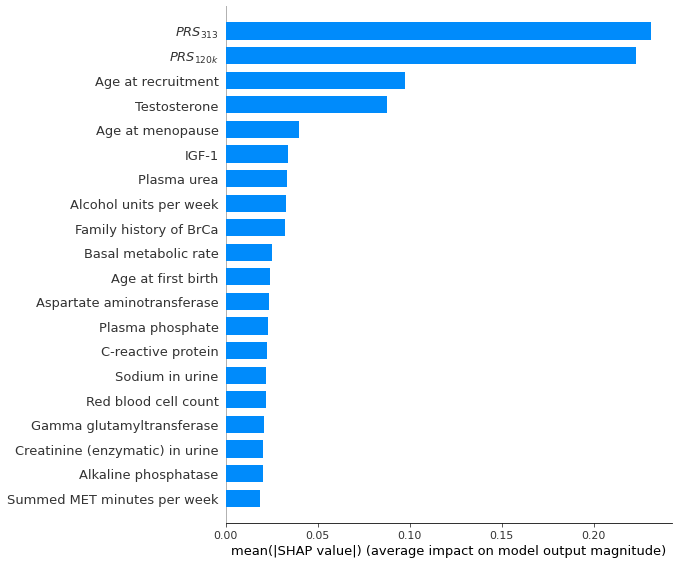

In [71]:

# Get pretty names
ohe_cat=column_trans.named_transformers_["cat"]
feature_names=ohe_cat.get_feature_names(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

pretty_features=np.asarray([pretty_names[var] for var in feature_names])

# summary plot
shap.summary_plot(shap_values,pretty_features,plot_type="bar")

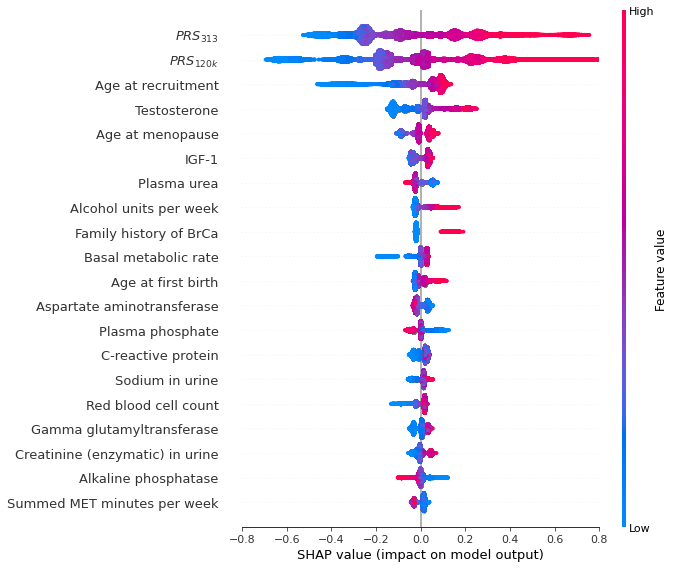

In [99]:
# Get pretty names
ohe_cat=column_trans.named_transformers_["cat"]
feature_names=ohe_cat.get_feature_names(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

pretty_features=np.asarray([pretty_names[var] for var in feature_names])

# summary plot
shap.summary_plot(shap_values,dtrain,feature_names=pretty_features,show=False)
# Do not use shap.beeswarm function, use above instead.

ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(-0.8, 0.8) 
plt.show()

In [ ]:

# Get pretty names
ohe_cat=column_trans.named_transformers_["cat"]
feature_names=ohe_cat.get_feature_names(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

pretty_features=np.asarray([pretty_names[var] for var in feature_names])

# summary plot
shap.summary_plot(shap_values,pretty_features,plot_type="bar")

In [73]:
# Export full SHAP to csv
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(feature_names,pretty_features,vals)),columns=['Var_name','Full_name','SHAP'])
feature_importance.sort_values(by=['SHAP'],ascending=False,inplace=True)
feature_importance.head()

feature_importance.to_csv("K:/TEU/MLforBrCa/Stats_Outputs/XGBoost_Cox_SHAP.csv")

## Boruta with SHAP

In [87]:
# First make dtrain a pd dataframe
dtrain_df = pd.DataFrame(dtrain, columns = feature_names)
dtrain_df.shape

(83450, 3046)

Manually implement Boruta with SHAP for few iterations.

In [9]:

# Manually implement Boruta with SHAP for 2 iterations
# https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a

### initialize hits counter
hits = np.zeros((len(dtrain_df.columns)))

### repeat 2 times
for iter_ in range(2):
   ### make X_shadow by randomly permuting each column of X
   np.random.seed(iter_)
   X_shadow = dtrain_df.apply(np.random.permutation)
   X_shadow.columns = ['shadow_' + feat for feat in dtrain_df.columns]
   ### make X_boruta by appending X_shadow to X
   X_boruta = pd.concat([dtrain_df, X_shadow], axis = 1)
   # Fit XGBoost 
   xgb_final=XGBClassifier(**best_params_xgb.item()['Best_params'])

   xgb_final.fit(X_boruta,Y)

   # Compute SHAP values 
   explainer = shap.TreeExplainer(xgb_final) # Without specifying data, it would use feature_perturbation="tree_path_dependant" and fast!

   shap_values_all=explainer.shap_values(X_boruta)
   
   vals= np.abs(shap_values_all).mean(0)
   #feature_importance = pd.DataFrame(list(zip(feature_names,pretty_features,vals)),columns=['Var_name','Full_name','SHAP'])

   ### store feature importances
   feat_imp_X = vals[:len(dtrain_df.columns)]
   feat_imp_shadow = vals[len(dtrain_df.columns):]
   ### compute hits for this trial and add to counter
   hits += (feat_imp_X > feat_imp_shadow.max())



[09:18:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:02:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:

# Investigate results
hits.shape

# Check freq table of hits
unique, counts = np.unique(hits, return_counts=True)
print(np.asarray((unique, counts)).T)

# Check which features have more than 1 hit
result = np.where(hits >=1)
feature_names[result]

# Compute p-values
import scipy as sp

def binomial_H0_test(array, n, p, alternative):
        """
        Perform a test that the probability of success is p.
        This is an exact, two-sided test of the null hypothesis
        that the probability of success in a Bernoulli experiment is p
        """
        return [sp.stats.binom_test(x, n=n, p=p, alternative=alternative) for x in array]  

# Compute p-values for acceptance and rejection
iteration=2
acceptance_p_values = binomial_H0_test(hits,
                                                    n=iteration,
                                                    p=0.5,
                                                    alternative='greater')
regect_p_values = binomial_H0_test(hits,
                                                n=iteration,
                                                p=0.5,
                                                alternative='less')

# Take the inverse as we want true to keep featrues
rejected_columns = np.array(regect_p_values) < 0.05
accepted_columns = np.array(acceptance_p_values) < 0.05    

# Why no sig?
feature_names[accepted_columns]
np.min(acceptance_p_values)

Auto compute using `Borutashap package`

In [88]:
# Try Boruta with SHAP

xgb_final=XGBRegressor(
    learning_rate=0.01,
    n_estimators=1635,
    max_depth=2,
    min_child_weight=3,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=20, #Similar to Ridge
    objective= 'survival:cox',
    random_state=0
)

Feature_Selector = BorutaShap(model=xgb_final,
                              importance_measure='shap',
                              classification=True)

Feature_Selector.fit(X=dtrain_df, y=Y, n_trials=100, sample=False,
		     verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Warning there are missing values in your data !


100%|██████████| 100/100 [9:41:04<00:00, 348.65s/it]   

14 attributes confirmed important: ['TEU_BrCa_313_PRS', 'BlA_NeutrophCount', 'BBC_IGF1_Result', 'FSF_MenopauseAge', 'TEU_BrCa_100k_PRS', 'TEU_FirstBirthAge', 'BBC_TES_Result', 'TEU_FaH_BrCa_Family history of BrCa', 'BBC_PHOS_Result', 'BBC_GGT_Result', 'TEU_Alc_WeeklyAlcUnits', 'BBC_BUN_Result', 'TEU_BaC_AgeAtRec', 'Imp_BodyFatMass']
3032 attributes confirmed unimportant: ['M05BA', 'TEU_HES_H55_prev_Yes', 'TEU_HES_M70_prev_Yes', 'TEU_HES_F22_prev_Yes', 'V06DC', 'TEU_HES_G03_prev_No', 'TEU_HES_K28_prev_No', 'TEU_CaR_C38_prev', 'TEU_HES_I06_prev_No', 'TEU_HES_T92_prev_Yes', 'TEU_HES_Q13_prev_No', 'TEU_HES_N29_prev_Yes', 'TEU_HES_R68_prev_No', 'C09AA', 'TEU_HES_B81_prev_No', 'TEU_HES_R46_prev_Yes', 'A12BA', 'V03AE', 'TEU_HES_R21_prev_Yes', 'TEU_HES_G99_prev_Yes', 'PhA_WalkingPace_Steady average pace', 'TEU_HES_H74_prev_No', 'A08AA', 'TEU_HES_L03_prev_No', 'TEU_HES_S80_prev_No', 'TEU_HES_K83_prev_No', 'M03BC', 'M01AB', 'TEU_HES_H34_prev_Yes', 'BlA_WhiteBCCount', 'BBC_ALT_Result', 'J01CF', '

In [89]:
#Save results
# Didn't use the default function below because I want to merge results from shap
#Feature_Selector.results_to_csv(filename="K:/TEU/MLforBrCa/Stats_Outputs/BorutaSHAP_100iter")

# Import results of Borutashap into a pd dataframe
Boruta_shap = pd.DataFrame(data={'Features':Feature_Selector.history_x.iloc[1:].columns.values,
        'Average Feature Importance':Feature_Selector.history_x.iloc[1:].mean(axis=0).values,
        'Standard Deviation Importance':Feature_Selector.history_x.iloc[1:].std(axis=0).values})

decision_mapper = Feature_Selector.create_mapping_of_features_to_attribute(maps=['Tentative','Rejected','Accepted', 'Shadow'])
Boruta_shap['Decision'] = Boruta_shap['Features'].map(decision_mapper)
Boruta_shap = Boruta_shap.sort_values(by='Average Feature Importance',ascending=False)

In [92]:
# Combine the Borutashap results with SHAP results
XGBoost_shap=pd.read_csv("K:/TEU/MLforBrCa/Stats_Outputs/ML coxloss/XGBoost_Cox_SHAP.csv")

# Left join with Borutashap results
XGBoost_Borutashap=Boruta_shap.merge(XGBoost_shap,left_on='Features',right_on='Var_name',how='left')

XGBoost_Borutashap.columns

XGBoost_Borutashap.drop(['Unnamed: 0', 'Var_name'],axis=1).to_csv("K:/TEU/MLforBrCa/Stats_Outputs/ML coxloss/XGBoost_BorutaSHAP.csv")

In [93]:
# Returns a subset of the original data with the selected features
subset = Feature_Selector.Subset()

for i in subset.columns:
    print(pretty_names[i])

$PRS_{313}$
Neutrophils count
IGF-1
Age at menopause
$PRS_{120k}$
Age at first birth
Testosterone
Family history of BrCa
Plasma phosphate
Gamma glutamyltransferase
Alcohol units per week
Plasma urea
Age at recruitment
Whole body fat mass


# SHAP Interactions

In [74]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(feature_names,pretty_features,vals)),columns=['Var_name','Full_name','SHAP'])
feature_importance.sort_values(by=['SHAP'],ascending=False,inplace=True)

feature_importance.head(10)

,Var_name,Full_name,SHAP
2403,TEU_BrCa_313_PRS,$PRS_{313}$,0.231164
2404,TEU_BrCa_100k_PRS,$PRS_{120k}$,0.223128
2402,TEU_BaC_AgeAtRec,Age at recruitment,0.097639
2530,BBC_TES_Result,Testosterone,0.087909
2453,FSF_MenopauseAge,Age at menopause,0.040110
2524,BBC_IGF1_Result,IGF-1,0.034031
2514,BBC_BUN_Result,Plasma urea,0.033166
2935,TEU_Alc_WeeklyAlcUnits,Alcohol units per week,0.032548
337,TEU_FaH_BrCa_Family history of BrCa,Family history of BrCa,0.032402
2422,Imp_MetRate,Basal metabolic rate,0.025108


In [ ]:
# Try a different colour map for SHAP dependence plot

shap.dependence_plot("Age at recruitment, years", shap_values, dtrain,feature_names=pretty_features,interaction_index='$PRS_{120k}$',cmap=plt.get_cmap("coolwarm"))

shap.dependence_plot("Age at recruitment, years", shap_values, dtrain,feature_names=pretty_features,interaction_index='$PRS_{120k}$',cmap=plt.get_cmap("bwr"))

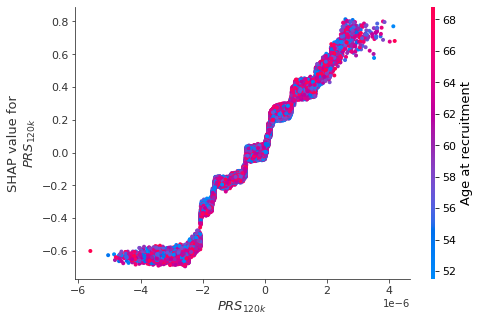

<Figure size 864x864 with 0 Axes>

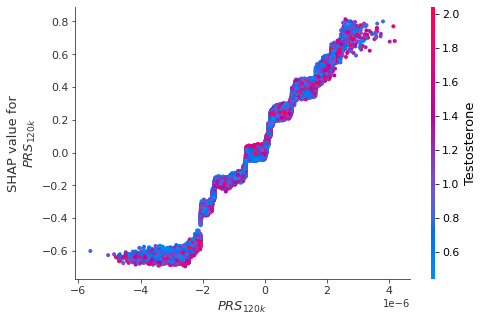

<Figure size 864x864 with 0 Axes>

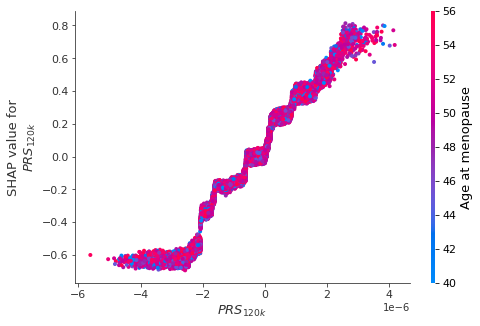

<Figure size 864x864 with 0 Axes>

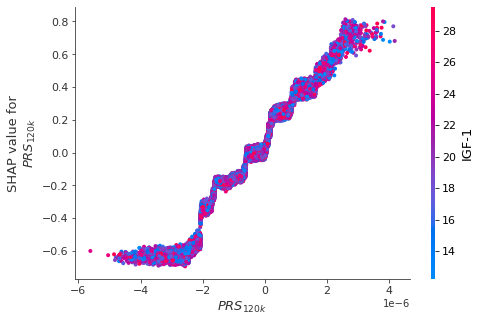

<Figure size 864x864 with 0 Axes>

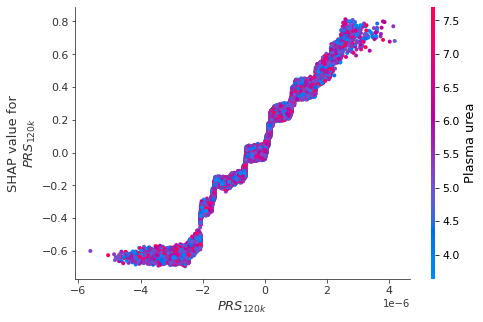

<Figure size 864x864 with 0 Axes>

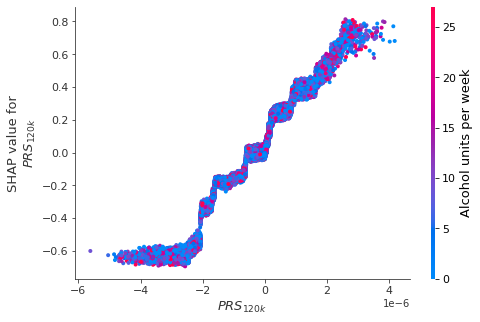

<Figure size 864x864 with 0 Axes>

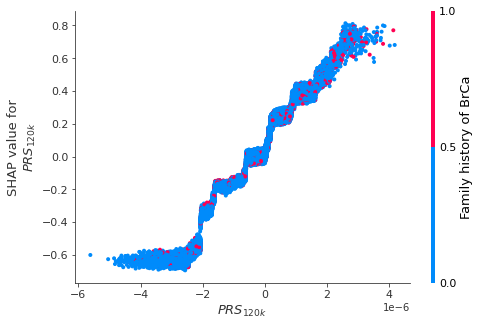

<Figure size 864x864 with 0 Axes>

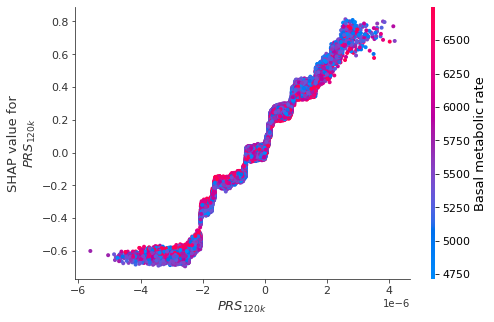

<Figure size 864x864 with 0 Axes>

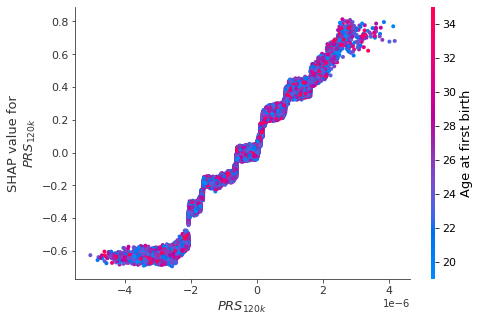

<Figure size 864x864 with 0 Axes>

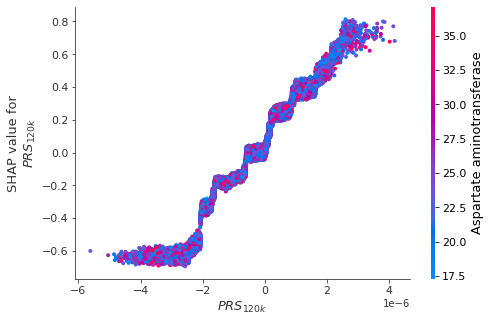

<Figure size 864x864 with 0 Axes>

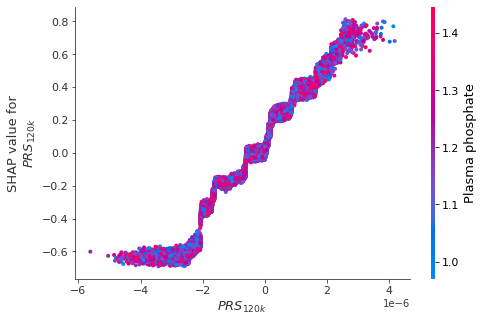

<Figure size 864x864 with 0 Axes>

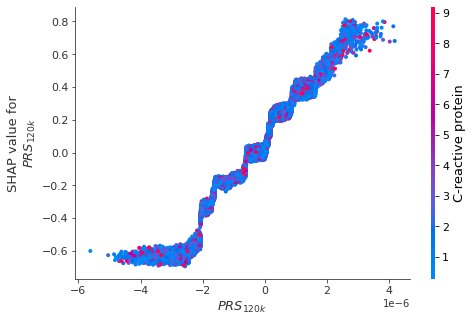

<Figure size 864x864 with 0 Axes>

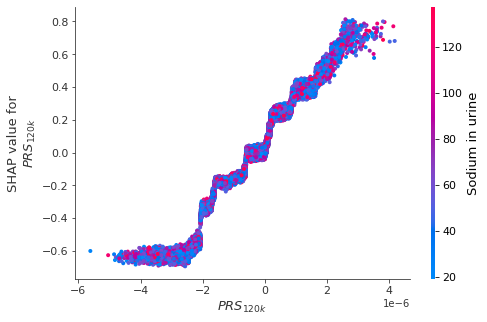

<Figure size 864x864 with 0 Axes>

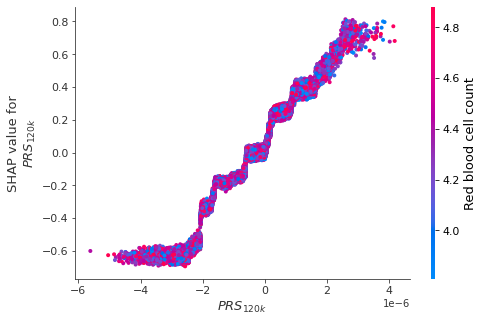

<Figure size 864x864 with 0 Axes>

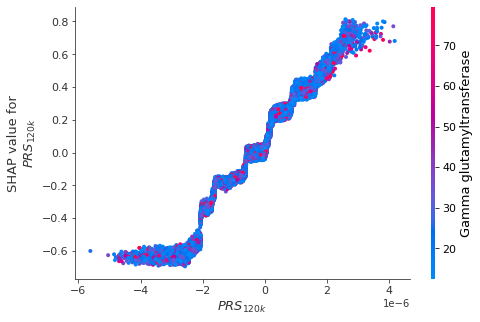

<Figure size 864x864 with 0 Axes>

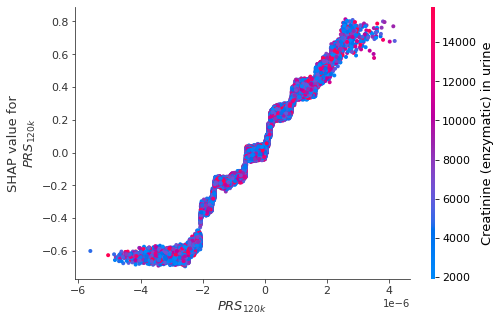

<Figure size 864x864 with 0 Axes>

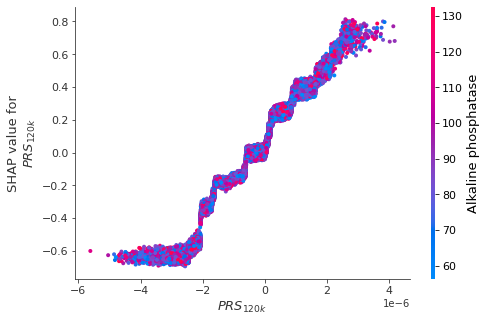

<Figure size 864x864 with 0 Axes>

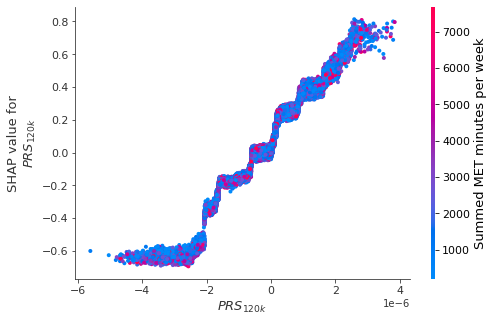

<Figure size 864x864 with 0 Axes>

In [75]:
# SHAP interaction plot but with x-axis being PRS and right y-axis being other phenotypic features
for name in feature_importance.Full_name[2:20]:
    shap.dependence_plot("$PRS_{120k}$",shap_values,dtrain,feature_names=pretty_features,interaction_index=str(name))
    f=plt.gcf()
    plt.savefig('K:\TEU\MLforBrCa\Stats_Outputs\ML coxloss\SHAP Plots\SHAP_'+str(name)+'_120kPRS.png',bbox_inches='tight')

In [ ]:
# Print interaction with 100k PRS

for name in feature_importance.Full_name[2:20]:
    shap.dependence_plot(str(name), shap_values, dtrain,feature_names=pretty_features,interaction_index='$PRS_{120k}$',show=False)
    f=plt.gcf()
    plt.savefig('K:\TEU\MLforBrCa\Stats_Outputs\ML coxloss\SHAP Plots\SHAP_120kPRS_'+str(name)+'.png',bbox_inches='tight')


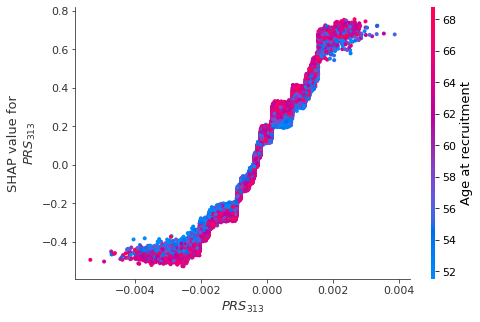

<Figure size 864x864 with 0 Axes>

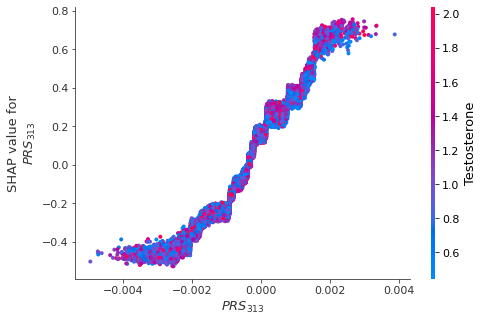

<Figure size 864x864 with 0 Axes>

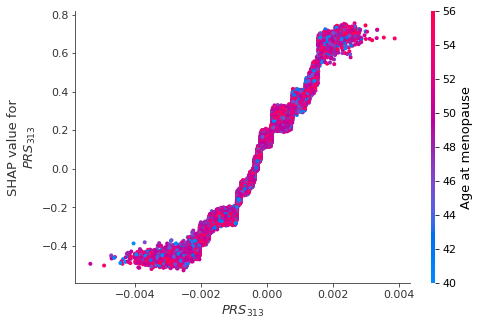

<Figure size 864x864 with 0 Axes>

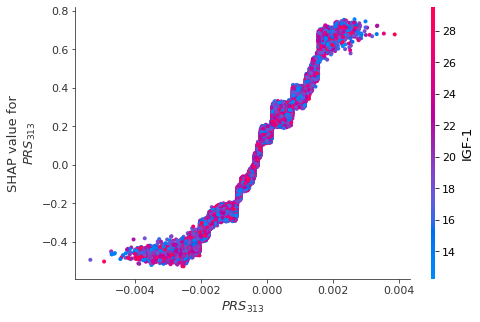

<Figure size 864x864 with 0 Axes>

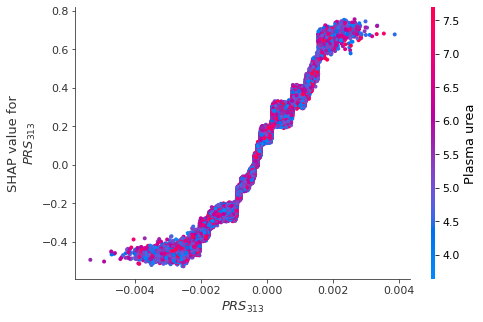

<Figure size 864x864 with 0 Axes>

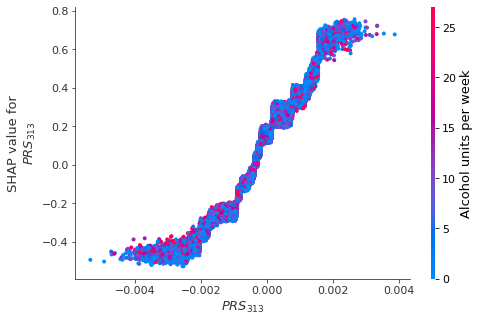

<Figure size 864x864 with 0 Axes>

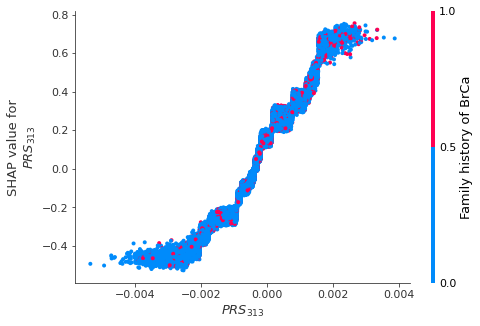

<Figure size 864x864 with 0 Axes>

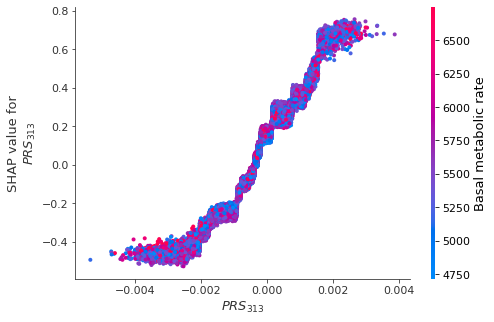

<Figure size 864x864 with 0 Axes>

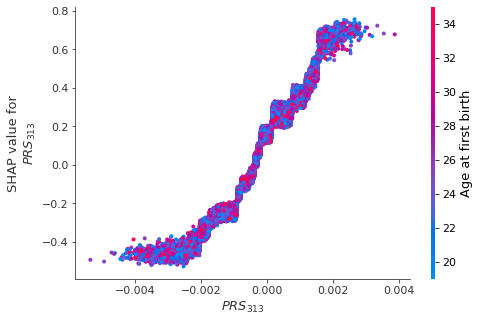

<Figure size 864x864 with 0 Axes>

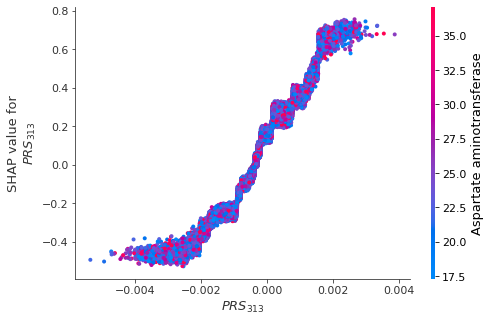

<Figure size 864x864 with 0 Axes>

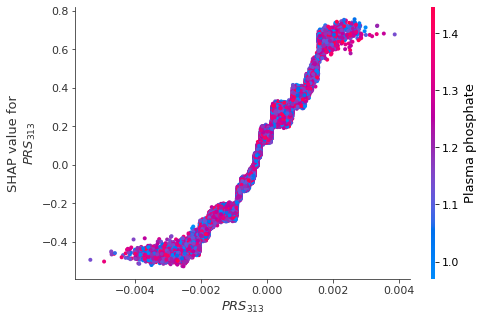

<Figure size 864x864 with 0 Axes>

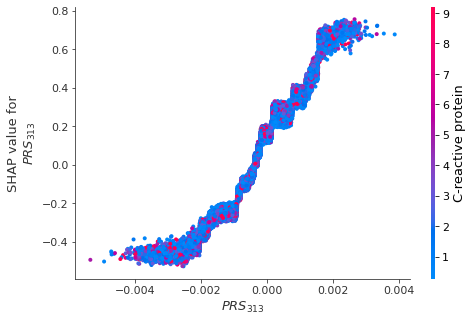

<Figure size 864x864 with 0 Axes>

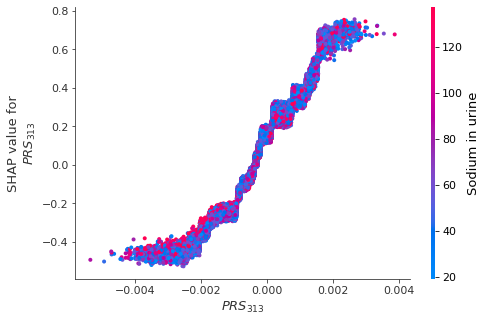

<Figure size 864x864 with 0 Axes>

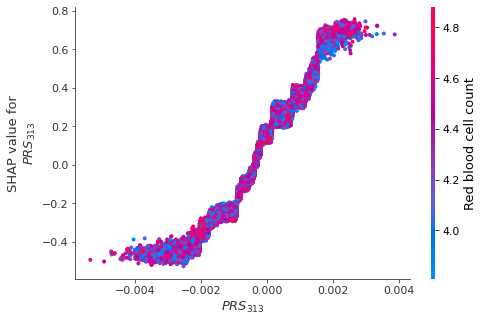

<Figure size 864x864 with 0 Axes>

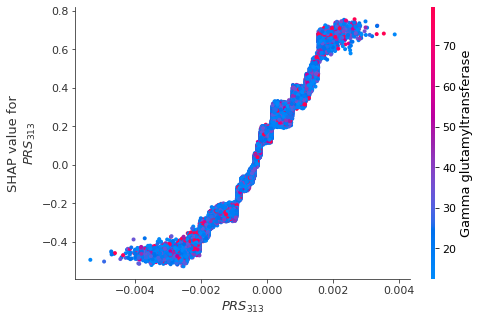

<Figure size 864x864 with 0 Axes>

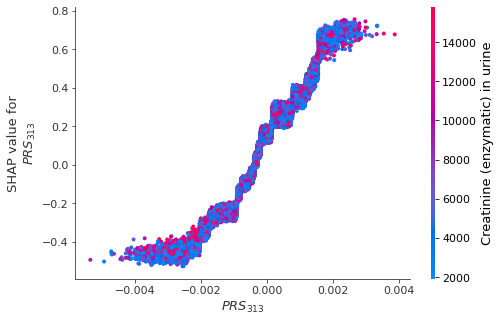

<Figure size 864x864 with 0 Axes>

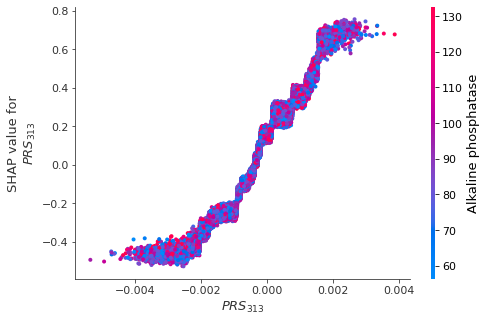

<Figure size 864x864 with 0 Axes>

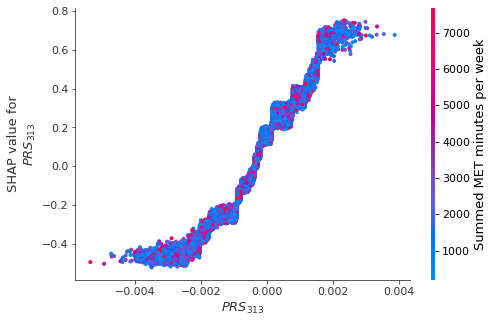

<Figure size 864x864 with 0 Axes>

In [76]:
# SHAP interaction plot with PRS as x-axis

for name in feature_importance.Full_name[2:20]:
    shap.dependence_plot("$PRS_{313}$",shap_values,dtrain,feature_names=pretty_features,interaction_index=str(name))
    f=plt.gcf()
    plt.savefig('K:\TEU\MLforBrCa\Stats_Outputs\ML coxloss\SHAP Plots\SHAP_'+str(name)+'_313PRS.png',bbox_inches='tight')

In [ ]:
# Print interaction with 313 PRS

for name in feature_importance.Full_name[2:20]:
    shap.dependence_plot(str(name), shap_values, dtrain,feature_names=pretty_features,interaction_index="$PRS_{313}$",show=False)
    f=plt.gcf()
    plt.savefig('K:\TEU\MLforBrCa\Stats_Outputs\ML coxloss\SHAP Plots\SHAP_313PRS_'+str(name)+'.png',bbox_inches='tight')


In [ ]:
# Plot age interactions

for name in feature_importance.Full_name[2:20]:
    shap.dependence_plot('Age at recruitment, years', shap_values, dtrain,feature_names=pretty_features,interaction_index=str(name))